# HW6: VAEs - Variational Autoencoders

In contrast to the previous notebook, this one will be a lot less of a primer and a lot more of a "show us what you can do!" In this notebook, you'll be making a variational autoencoder to reconstruct the MNIST digits. You will also need to do some evaluation on this model.

In [ ]:
# Enabling the GPU:
# Navigate to Edit → Notebook Settings
# Set Hardware Accelerator: GPU
## HIGHLY-RECOMMENDED TO USE GPU FOR THIS!

import tensorflow as tf
import numpy as np
import IPython.display  ## For displaying images/gifs generated in your lab

print('Tensorflow Version:', tf.__version__)
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

!nvidia-smi

Tensorflow Version: 2.9.2
Num GPUs Available: 1
Thu Dec  8 00:15:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                        

### Loading In The Dataset

In [ ]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np

def input_prep_fn(x):
    ## TODO: Perform preprocessing on the data as appropriate
    out = tf.cast(x, tf.float32)
    out = tf.expand_dims(out, -1)/255.0
    
    #out = tf.image.resize(out, [32,32])
    print(out.shape)

    return out

(X0, L0), (X1, L1) = tf.keras.datasets.mnist.load_data()

X0 = input_prep_fn(X0)
X1 = input_prep_fn(X1)

11490434/11490434 [==============================] - 1s 0us/step
(60000, 28, 28, 1)
(10000, 28, 28, 1)


## Part 1: Implement a VAE

For this part of the assignment, you are free (or actually even encouraged) to check out the official Tensorflow Tutorial on [Convolutional Variational Autoencoders](https://www.tensorflow.org/tutorials/generative/cvae), which shows how to train up a simple VAE to perform well on the MNIST dataset. For your task, we want you to take inspiration and intuition from their method and add on some specialized properties. Not only will this allow you to make a more user-friendly object-oriented VAE component, but it will also be useful for the subsequent step where we will need to implement a modified version.

**Model:**

Your version of the VAE model must be modular and needs to contain AT LEAST the following methods:**
- Constructor that takes in AT LEAST encoder/decoder components. 
- Call function which passes the input through the encoder, latent_ops, and decoder methods. 
    - This method should actually take in a tuple of (input image, input label). This may seem weird since we're not using the label yet, but that will be necessary for the next part. 
- `latent_ops` method that performs operations on the bottlenecked latent space (i.e. output of encoder).
- `sample_z` method that generates a random realization based on encoder output. 
- `compile` override that takes in both a KL Divergence loss function and a reconstruction loss function. 
- Whatever other modifications you'd like to make. 

**Loss Function:**
- The tutorial demonstrates how to create a combined ELBO loss. Their version of the loss takes in both the image truth/reconstruction, but also the latent components from the bottleneck layer. An issue with this approach is that it is difficult to identify how much each component of the loss is contributing to your training while also restricting you from easily modifying the individual components of this combined loss term. Instead of their version, we can create separate reconstruction and kl-divergence loss functions and use them both within our loop. 
    - Skim over the [Wikipedia article covering KL Divergence](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence), and you will notice that there is a relatively simple equation that can compute the relative entropy between a "diagonal multivariate normal" and a standard normal distribution. Coincidentally, since our VAE samples from a learned distribution parameterized by a per-entry mean and log-variance, this counts as a diagonal multivariate normal (if our normal realizations were not independently distributed, this would not have been the case since the random normal generation would have had contributions from other \*columns\* of the random matrix). The math details are not important; the fact is that the formula stands and can be used to encourage our network to tend the mean/logvar predictions towards a standard normal (or at least try to keep it from going too far away). 
    - For the reconstruction loss, sum the binary crossentropy between the true pixels and the predicted pixels for each entry. 
    - For both components, feel free to just return a batch of sums. Keras will take care of the rest for you. 
    - These custom loss functions should be passed into an overridden `compile` method which should save them to instance variables and use them later. 
    - To help you keep track of your KLD/reconstruction loss evaluations, you should create Mean trackers in your model constructor. Then, any time you compute a loss component, just update is at appropriate! Search for `metrics.Mean` in [the fit method tutorial](https://keras.io/guides/customizing_what_happens_in_fit/) to check out what this might look like. You should report both statistics while your model is training.

**Training:** 
- Please construct your model using the arguments found in the [Convolutional VAE tutorial](https://www.tensorflow.org/tutorials/generative/cvae) mentioned above. You **DO NOT** want to try to find your own parameters/architecture for this assignment; trust me. 
    - **Recommendation**: Feel free to change all of your non-output layers are leaky-relu-activated and your output layer is sigmoid-activated. Also, we found the learning rate of 5e-3 to be quite nice!
    - Also make sure that your mu_layers and lv_layers variables output 2 features. This will be important for later visualizations. 
- Please be mindful on how much time you're using. This assignment encourages you to use a GPU since the process can be a bit slow. When you're not using it, go ehead and disconnect from it so that you don't get throttled by Google Colab.

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.math import exp, sqrt, square

## One possible implementation: VAE

class VAE(tf.keras.Model):

    # init          : ?
    # call          : x, label -> VAE(x)
    # latent_ops    : z -> ...
    # compile       : rec_loss, kld_loss, ... -> None
    # sample_z      : None -> z

    # HINT: A line from our init: 
    #     self.kld_tracker = tf.keras.metrics.Mean(name="kld") 

    ##########################################################
    ## Custom batch step methods

    def __init__(self, encoder, decoder):
      super().__init__()
      self.encoder = encoder
      self.decoder = decoder
      self.kld_tracker = tf.keras.metrics.Mean(name="kld") 
      self.rec_tracker = tf.keras.metrics.Mean(name="rec")
      self.mu_layer = Dense(2, activation = "leaky_relu")
      self.lv_layer = Dense(2, activation = "leaky_relu")

    def call(self, inputs):
      x, label = inputs
      # print('label', label)
      output = self.encoder(x)
      # print('output1', output)

      output = self.latent_ops(output)
      # print('output2', output)
      output = self.decoder(output)
      #print('output', output)
      return output

    def latent_ops(self, z):
      self.mu = self.mu_layer(z)
      self.lv = self.lv_layer(z)
      z = self.sample_z()
      return z

    def sample_z(self):
      eps = tf.random.normal(shape=self.mu.shape)
      sigma = sqrt(exp(self.lv))
      return self.mu + sigma * eps

    def compile(self, rec_loss, kld_loss,*args, **kwargs):
      super().compile(*args, **kwargs)
      self.rec_loss = rec_loss
      self.kld_loss = kld_loss
      

    def train_step(self, data): return self.batch_step(data, training=True)
    def test_step(self, data):  return self.batch_step(data, training=False)

    def batch_step(self, data, training=True):
        ## TODO: Implement the batch step method as appropriate.
        ##  Make sure that the return includes reconstruction and kl loss.
        (x, label), y = data

        with tf.GradientTape() as tape:
          preds = self((x, label), training=training)
          # print('preds', preds)
          kld_loss = self.kld_loss(self.mu, self.lv)
          # print('kld', kld_loss)

          rec_loss = self.rec_loss(y, preds)
          # print('rec_loss', rec_loss)

          loss = rec_loss + kld_loss
         # print(loss)
        if training:
          grad = tape.gradient(loss, self.trainable_variables)
          self.optimizer.apply_gradients(zip(grad,self.trainable_variables))
        
        self.compiled_metrics.update_state(y, preds)
        self.rec_tracker.update_state(rec_loss)
        self.kld_tracker.update_state(kld_loss)
        out = {m.name: m.result() for m in self.metrics}
        out = {
            **out,
            "rec": self.rec_tracker.result(),
            "kld": self.kld_tracker.result()
        }

        return out

In [ ]:
## TODO: Construct your model. 
## Take inspiration from the TF tutorial as well as the above instructions. 

encoder = tf.keras.Sequential(
    [
       
        tf.keras.layers.Conv2D(
            filters=32, kernel_size=3, strides=(2, 2), activation='leaky_relu'),
        tf.keras.layers.Conv2D(
            filters=64, kernel_size=3, strides=(2, 2), activation='leaky_relu'),
        tf.keras.layers.Flatten(),
            # No activation
      
    ],
    name = "ae_encoder"
)
decoder = tf.keras.Sequential(
    [
        
        tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
        tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
        tf.keras.layers.Conv2DTranspose(
            filters=64, kernel_size=3, strides=2, padding='same',
            activation='leaky_relu'),
        tf.keras.layers.Conv2DTranspose(
            filters=32, kernel_size=3, strides=2, padding='same',
            activation='leaky_relu'),
            # No activation
        tf.keras.layers.Conv2DTranspose(
            filters=1, kernel_size=3, strides=1, padding='same', activation = 'sigmoid'),
        #tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
     
    ],
    name = "ae_decoder"
)

vae_model = VAE(encoder, decoder)

## Summarize your model as well using the summary method. 
## You will need to build it first, so toss it some representative inputs.
vae_model((X0[:5], L0[:5]))
vae_model.summary()
vae_model.encoder.summary()
vae_model.decoder.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ae_encoder (Sequential)     (5, 2304)                 18816     
                                                                 
 ae_decoder (Sequential)     (5, 28, 28, 1)            41953     
                                                                 
 dense_1 (Dense)             multiple                  4610      
                                                                 
 dense_2 (Dense)             multiple                  4610      
                                                                 
Total params: 69,993
Trainable params: 69,989
Non-trainable params: 4
_________________________________________________________________
Model: "ae_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (5, 13, 13

In [ ]:
## TODO: Implement loss functions as appropriate

def kld_loss(lv, mu):
    # return ## TODO
    #print(0.5 * tf.reduce_sum( exp(lv) + square(mu) -1 - lv, axis = 1))
    return 0.5 * tf.reduce_sum( exp(lv) + square(mu) -1 - lv, axis = 1)

def rec_loss(x_true, x_pred):
    # return ## TODO
 
    return tf.reduce_sum(tf.keras.losses.binary_crossentropy(x_true, x_pred), axis = (1,2))

## TODO: Compile and fit your model on all or some of the dataset (depends on 
##  how slow it goed for you). You should make sure that it outputs reasonable 
##  accuracies and has reconstruction loss going below 160. 


## NOTE: To get reconstruction loss below 160, you will need to train on the
##  whole dataset or for longer iterations. Use a GPU for this. 

vae_model.compile(rec_loss, kld_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=5e-3), metrics = [
        tf.keras.metrics.MeanSquaredError(), 
        tf.keras.metrics.BinaryCrossentropy()
    ])
#tf.config.run_functions_eagerly(True)
# subset = 10000   ## If not using GPU, feel free to use this one
subset = 60000  ## Might get better results with whole dataset...
vae_model.fit(
    (X0[:subset], L0[:subset]), X0[:subset],
    epochs     = 20,
    batch_size = 100,
    validation_data = ((X1[:1000], L1[:1000]), X1[:1000]),
);

Epoch 1/20
600/600 [==============================] - 7s 8ms/step - mean_squared_error: 0.0571 - binary_crossentropy: 0.2307 - kld: 4.0313 - rec: 180.8884 - val_mean_squared_error: 0.0497 - val_binary_crossentropy: 0.2071 - val_kld: 4.8139 - val_rec: 162.3430
Epoch 2/20
600/600 [==============================] - 4s 6ms/step - mean_squared_error: 0.0507 - binary_crossentropy: 0.2110 - kld: 4.8538 - rec: 165.3853 - val_mean_squared_error: 0.0487 - val_binary_crossentropy: 0.2039 - val_kld: 4.8953 - val_rec: 159.8205
Epoch 3/20
600/600 [==============================] - 4s 6ms/step - mean_squared_error: 0.0499 - binary_crossentropy: 0.2085 - kld: 5.1482 - rec: 163.4300 - val_mean_squared_error: 0.0480 - val_binary_crossentropy: 0.2021 - val_kld: 5.1545 - val_rec: 158.4234
Epoch 4/20
600/600 [==============================] - 4s 6ms/step - mean_squared_error: 0.0494 - binary_crossentropy: 0.2069 - kld: 5.3397 - rec: 162.2035 - val_mean_squared_error: 0.0484 - val_binary_crossentropy: 0.203

When you've trained your model, check on it and just make sure that the below code shows off some of the predictions your model is making. Feel free to modify the code as appropriate if it doesn't seem to work. 

Your reconstructions should look pretty reasonable if your reconstruction loss is below 170. Note also that you can run your code for more epochs just by re-fitting as long as you don't reconstruct the model. So if you train for 10 epochs and you see it isn't enough, you can continue training. Just don't rebuild the model!

> **NOTE:** Any and all boilerplate from here-on worked with our implementation of the model. It's ok if it doesn't defautly work with yours; Just modify it accordingly so that everything is good!

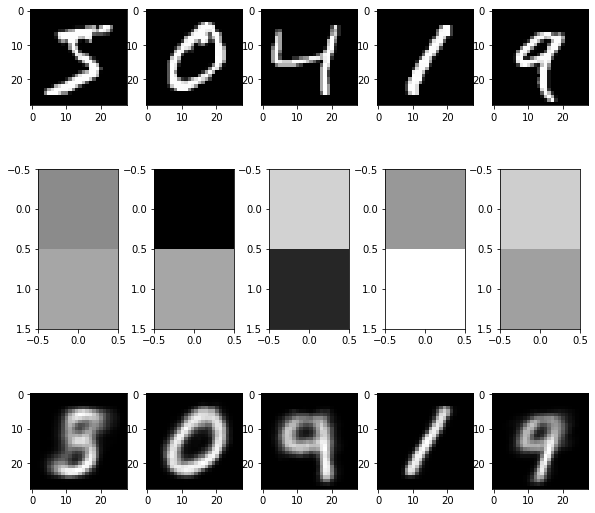

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(10, 10))

x  = X0[:5]
xp = vae_model.encoder(x)
zp = vae_model.latent_ops(xp)
z  = vae_model.decoder(zp)

min_zp = np.min(zp)
max_zp = np.max(zp)
scale_zp = lambda v: (v - min_zp) / (max_zp - min_zp)

for i in range(5):
    axs[0][i].imshow(x[i,:,:,0], cmap='gray')
    axs[1][i].imshow(tf.reshape(scale_zp(zp[i]), (2, 1)), cmap='gray', vmin=0, vmax=1)
    axs[2][i].imshow(z[i,:,:,0], cmap='gray')

After that, go ahead and visualize a segment of the latent space where you plot out what the different z-space configurations get decoded into. 

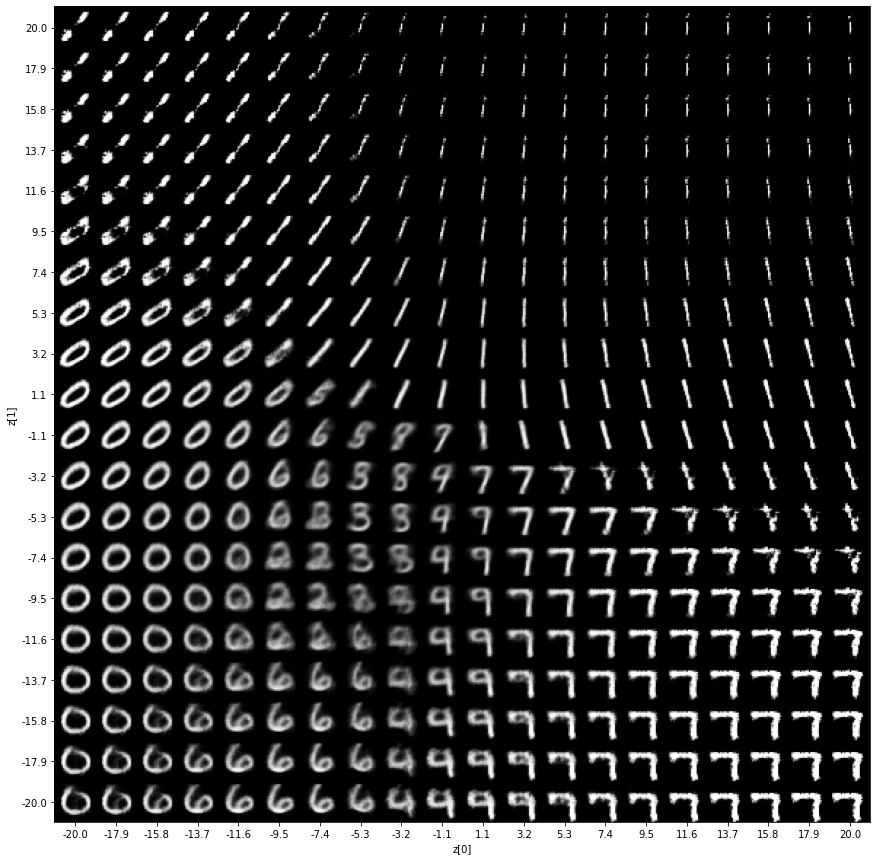

In [ ]:
def plot_latent_space(vae, n=20, figsize=15, digit_size=28):
    # display a n*n 2D manifold of digits
    scale = 20.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder(z_sample)
            digit = x_decoded[0, :, :, 0]
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="gray")
    plt.show()


plot_latent_space(vae_model)

As you might have noticed, your model probably doesn't seem to capture all of the numbers despite checking even larger values of z. This might also have been observed in your visualization earlier, since some numbers may have been presumptuously decoded into something straight out of another class. This may be because the latent space associated with those values is not as well-developed and might not be capable of giving proper reconstructions for such examples. 

To help resolve this, we can help our network along while still keeping to our 2-degrees-of-freedom bottleneck. 

## Part 2: Implement a Partially-Conditioned VAE

To help our decoder learn a more sprawling latent space, we can try using a flavor of "conditioned" VAEs to give the decoder some more information. The details of their logic and formulation is discussed in [a very nice blog post by Agustinus Kristiadi](https://agustinus.kristia.de/techblog/2016/12/17/conditional-vae/) which may be nice to read before starting on this. 

It's a bit non-trivial to inform the encoder about our class since the encoder input is an image, but we can trivially inform the decoder by just concatenating the label information to our sampled z vectors. Implement a `CVAE` model class that executes on this partially-conditioned VAE concept. 

Try to get reconstruction loss down below 135!

**HINT:** Depending on how you structure your VAE implementation, this part could take very few lines. Our implementation subclasses VAE and just overrides the call method....

In [ ]:
class CVAE(VAE):
    ## TODO

    def call(self, inputs):
      x, label = inputs
      label = tf.one_hot(label, 10)
      output = self.encoder(x)
      output = self.latent_ops(output)
      output = tf.concat([output, label], axis = -1)
      output = self.decoder(output)
      return output

In [ ]:
## TODO: Construct your model. This should look identical except now for CVAE

encoder = tf.keras.Sequential(
    [
       
        tf.keras.layers.Conv2D(
            filters=32, kernel_size=3, strides=(2, 2), activation='leaky_relu'),
        tf.keras.layers.Conv2D(
            filters=64, kernel_size=3, strides=(2, 2), activation='leaky_relu'),
        tf.keras.layers.Flatten(),
            # No activation
      
    ],
    name = "ae_encoder"
)
decoder = tf.keras.Sequential(
    [
        
        tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
        tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
        tf.keras.layers.Conv2DTranspose(
            filters=64, kernel_size=3, strides=2, padding='same',
            activation='leaky_relu'),
        tf.keras.layers.Conv2DTranspose(
            filters=32, kernel_size=3, strides=2, padding='same',
            activation='leaky_relu'),
            # No activation
        tf.keras.layers.Conv2DTranspose(
            filters=1, kernel_size=3, strides=1, padding='same', activation = 'sigmoid'),
        #tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
     
    ],
    name = "ae_decoder"
)


cvae_model = CVAE(encoder, decoder)


## Summarize your model as well using the summary method. 
## You will need to build it first, so toss it some representative inputs.
cvae_model((X0[:5], L0[:5]))
cvae_model.summary()
cvae_model.encoder.summary()
cvae_model.decoder.summary()

Model: "cvae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ae_encoder (Sequential)     (5, 2304)                 18816     
                                                                 
 ae_decoder (Sequential)     (5, 28, 28, 1)            57633     
                                                                 
 dense_4 (Dense)             multiple                  4610      
                                                                 
 dense_5 (Dense)             multiple                  4610      
                                                                 
Total params: 85,673
Trainable params: 85,669
Non-trainable params: 4
_________________________________________________________________
Model: "ae_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (5, 13, 1

In [ ]:
  ## TODO


cvae_model.compile(rec_loss, kld_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=5e-3), metrics = [
        tf.keras.metrics.MeanSquaredError(), 
        tf.keras.metrics.BinaryCrossentropy()
    ])

# subset = 10000   ## If not using GPU, feel free to use this one
subset = 60000  
cvae_model.fit(
    (X0[:subset], L0[:subset]), X0[:subset],
    epochs     = 10,
    batch_size = 100,
    validation_data = ((X1[:1000], L1[:1000]), X1[:1000]),
);

Epoch 1/10
600/600 [==============================] - 6s 9ms/step - mean_squared_error: 0.0474 - binary_crossentropy: 0.2040 - kld: 3.2773 - rec: 159.9046 - val_mean_squared_error: 0.0410 - val_binary_crossentropy: 0.1816 - val_kld: 3.4672 - val_rec: 142.3455
Epoch 2/10
600/600 [==============================] - 5s 8ms/step - mean_squared_error: 0.0389 - binary_crossentropy: 0.1773 - kld: 4.2539 - rec: 138.9822 - val_mean_squared_error: 0.0388 - val_binary_crossentropy: 0.1752 - val_kld: 4.2919 - val_rec: 137.3709
Epoch 3/10
600/600 [==============================] - 4s 6ms/step - mean_squared_error: 0.0381 - binary_crossentropy: 0.1750 - kld: 4.4410 - rec: 137.1757 - val_mean_squared_error: 0.0392 - val_binary_crossentropy: 0.1767 - val_kld: 4.2685 - val_rec: 138.5560
Epoch 4/10
600/600 [==============================] - 4s 7ms/step - mean_squared_error: 0.0376 - binary_crossentropy: 0.1737 - kld: 4.5276 - rec: 136.1501 - val_mean_squared_error: 0.0383 - val_binary_crossentropy: 0.174

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(10, 10))

x  = X0[:5]
xp = cvae_model.encoder(x)
zp = cvae_model.latent_ops(xp)
zp_lab = tf.concat([zp, tf.one_hot(L0[:5], 10)], axis=-1)
z  = cvae_model.decoder(zp_lab)

min_zp = np.min(zp)
max_zp = np.max(zp)
scale_zp = lambda v: (v - min_zp) / (max_zp - min_zp)

for i in range(5):
    axs[0][i].imshow(x[i,:,:,0], cmap='gray')
    axs[1][i].imshow(tf.reshape(scale_zp(zp[i]), (2, 1)), cmap='gray', vmin=0, vmax=1)
    axs[2][i].imshow(z[i,:,:,0] * 0.5 + 1, cmap='gray')

Now that we can condition our decoding on a specific label, we can go ahead and visualize the latent space as we very the label being queried for. 

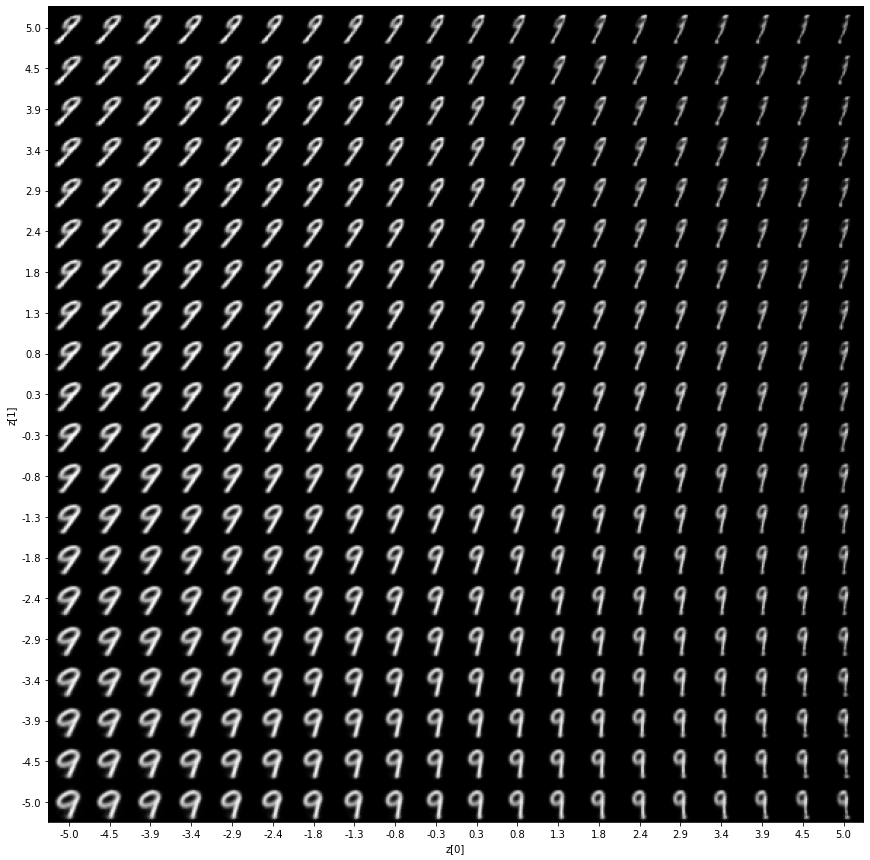

In [ ]:
def plot_latent_space(vae, n=20, label=0, figsize=15, digit_size=28):
    # display a n*n 2D manifold of digits
    scale = 5.0
    figure = np.zeros((digit_size * n, digit_size * n))
    label_ohe = tf.one_hot(label, 10)
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([tf.concat([[xi, yi], label_ohe], -1)])
            x_decoded = vae.decoder(z_sample)
            digit = x_decoded[0, :, :, 0]
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="gray")
    plt.show()


plot_latent_space(cvae_model, label=9)

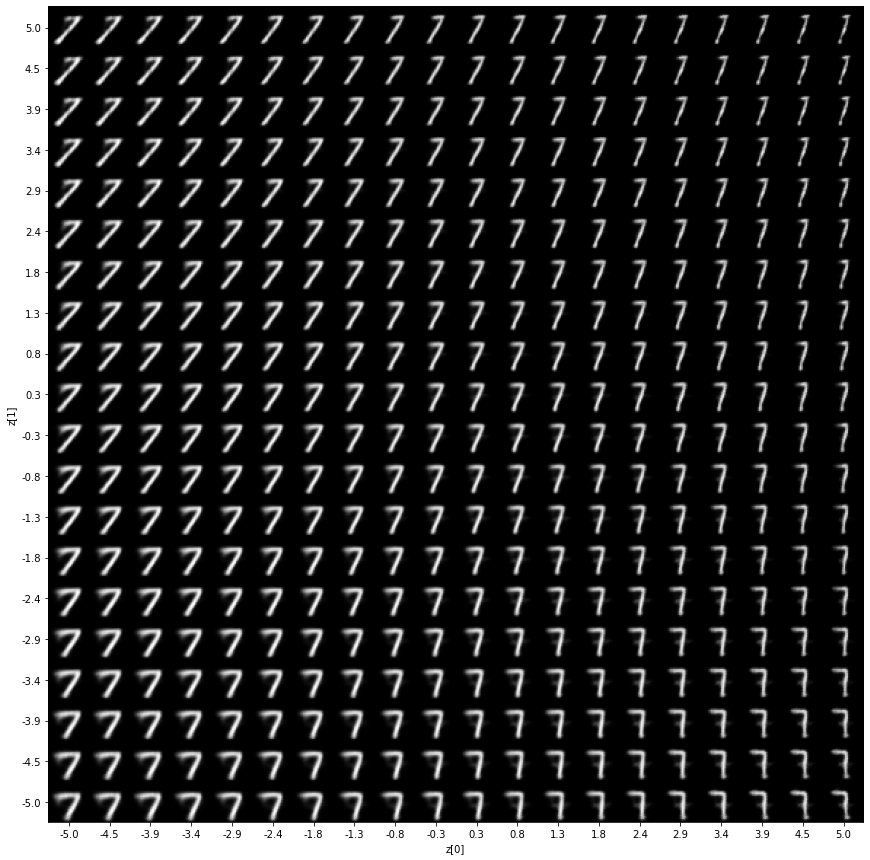

In [ ]:
plot_latent_space(cvae_model, label=7)

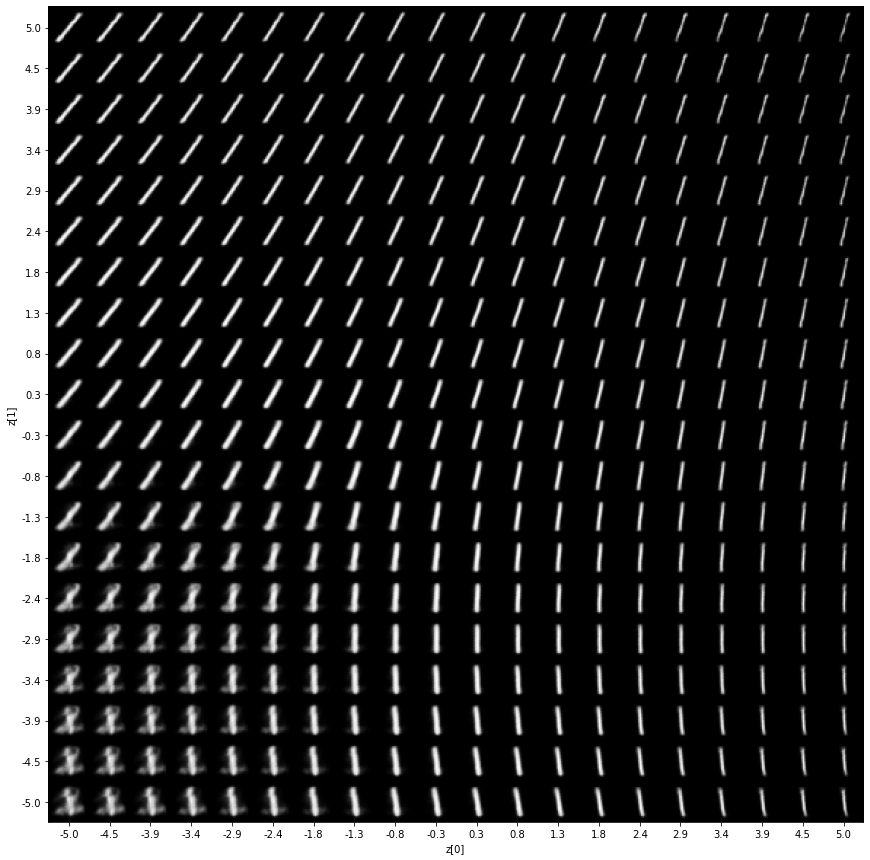

In [ ]:
plot_latent_space(cvae_model, label=1)

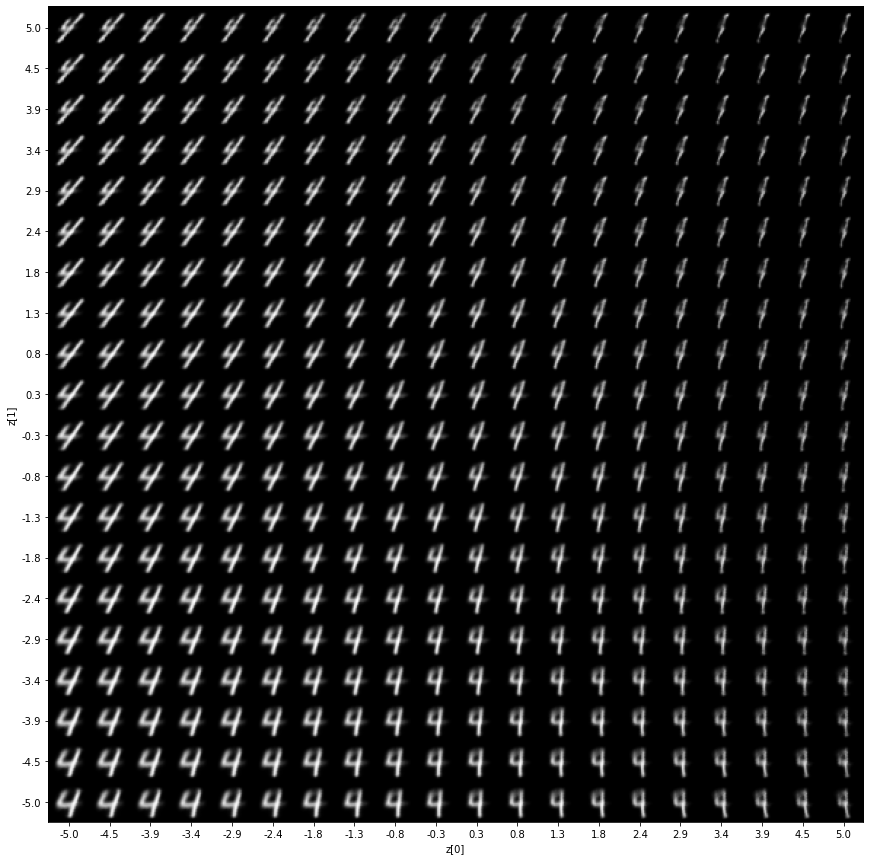

In [ ]:
plot_latent_space(cvae_model, label=4)

Awesome! As we can see, conditioning the decoder with a label will change the latent space such that every naturally-sampled z-vector results in some variation of the desired letter. If you look between the different latent space visualizations, you may notice a pattern forming where a consistent quadrant of them is thicker and aligned one way while a different quadrant might be skinnier and aligned the other way. It would be interesting to see if we could walk between these digits and see how the decoding changes as we progress from one digit to another...

## Part 3: A Latent Walk Between Digits

We can try to interpolate between the label components of the decoder input and see what happens to our output. If we're lucky, this walk may show a progressive transformation through all of the classes. The code below starts you off and discusses how this might be achieved. You may need to modify some of this for your needs depending on your settled model architecture. 

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import io

interp_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0]

time_steps = 11

z0_opts = (-5., 0.1, 5.)  ## IMPORTANT: Make sure these have a dot (for float)
z1_opts = (-5., 0.1, 5.)

interp_labels = [tf.one_hot(x, 10) for x in interp_labels]

def fig2img(fig):
    """
    Convert a Matplotlib figure to a PIL Image and return it
    https://stackoverflow.com/a/61754995/5003309
    """
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    return Image.open(buf)

imgs = []

total_frames = time_steps * (len(interp_labels) - 1)
for lab_idx, (lab0, lab1) in enumerate(zip(interp_labels[:-1], interp_labels[1:])):
    ## For every adjacent pair of labels
    for frame, lab in enumerate(np.linspace(lab0, lab1, time_steps)):
        ## Compute a span of labels going progressively from one to the other
        fig, axs = plt.subplots(nrows=len(z0_opts), ncols=len(z1_opts), figsize=(10, 10))
        fig.suptitle(f'Label {np.round(lab, 1)}', fontsize=20)
        for j, z0 in enumerate(z0_opts):
            for k, z1 in enumerate(z1_opts):
                ## Find every pair of latent coordinates, and find the prediction 
                ## of current walked label at that z coordinate
                z_lab = np.array([tf.concat([[z0, z1], lab], axis=-1)])
                x_pred = cvae_model.decoder(z_lab)[0, :, :, 0]
                axs[j][k].imshow(x_pred, cmap='gray', vmin=0, vmax=1)
        ## Log the fact that this image was generated, and add to frames list
        curr_frame = time_steps * lab_idx + frame
        print(f'\rPrinted frame {1 + time_steps * lab_idx + frame}/{total_frames}', end='')
        imgs += [fig2img(fig)]
        plt.close(fig)

Printed frame 110/110

The code keeps track of the frames seen and these can be subsequently saved to a gif file. Don't forget to download said gif file and attach it to your homework submission!

In [ ]:
imgs[0].save(
    'latent_walk.gif', save_all=True, append_images=imgs[1:], 
    loop=0, duration=100)

In [ ]:
IPython.display.Image(open('latent_walk.gif','rb').read())

Output hidden; open in https://colab.research.google.com to view.

## **[FOR CREDIT]**
- Make sure both of your gifs are present in the notebook!
- Talk about a potential application that you think it would be cool to applied VAEs to. 

# Final Notes (for after you finish)

## Congrats!

You just finished the last assignment in Deep Learning!! 

(Aside from the final project...)

Really hope you've had a great time with the course and hope to see you around!

Best of luck!

Chen and all of the TAs!

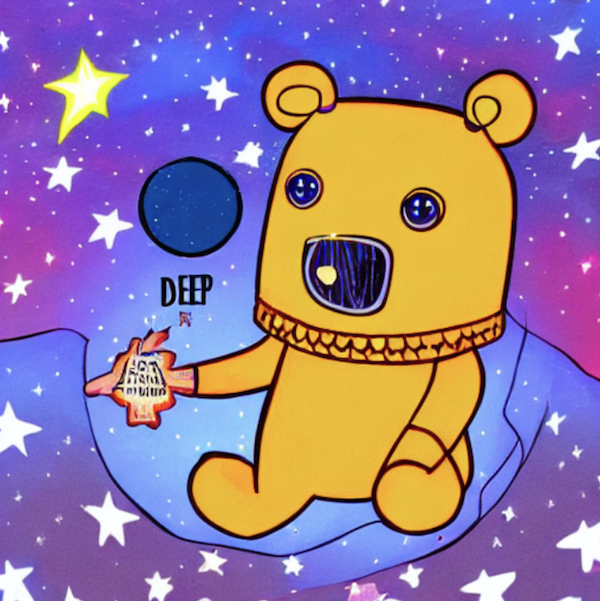